# A5

In [50]:
# Standard Imports
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

import Network as NN
import importlib
import mnist_loader

import copy
import random

# Q1: Electrophysiology Experiment

In [51]:
import lif

def MonkeyFixationSpikes(x, T, pop):
    """
    spike_times = MonkeyFixationSpikes(x, T, pop)

    Given the gaze direction, outputs the spiking activity of the monkey's
    neurons.

    Input:
      x is the monkey's gaze direction
      T is the duration of the fixation (in seconds)
      pop is a 6xN matrix of LIF parameters

    Output:
      spike_times is an list containing N arrays of time-stamps indicating
        when each neuron fired.  
    """
    dt = 0.001  # time-step size for simulations
    xts = x*np.ones(int(T/dt))
    sp, v = lif.Stim2Spikes(xts, dt, pop, interp=True)
    return sp

In [220]:
#=====================
# CHOOSE A MONKEY
# The monkey's are numbered 0, 1, 2, 3, and 4.
# This will read in the LIF parameters for the monkey's neurons
# as well as the spiking trains for the unknown sequence.
#=====================
infile = open('monkey3.npz', 'rb')
varsin = np.load(infile)
pop = varsin['pop']   # parameters for population of neurons
Asp = varsin['Asp']   # spike trains for unknown sequence
N = len(pop[1])  # number of neurons

## (a) Behavioural Sampling Experiment

In [259]:
# Select a spread of stimulus values from 0 to 9. Choose at least 100 samples.

# ***** YOUR CODE HERE *****

X = np.random.uniform(-1,10,[100,])
X.sort()

A = np.zeros((100,N))
for idx in range(100):
    sp = MonkeyFixationSpikes(X[idx],0.4,pop)
    
    for i,s in enumerate(sp):
        if len(s) == 0:
            A[idx, i] = 0
        else:
            prev = s[0]
            s_rates = []
            for cur in s[1:]:
                rate = 1 / (cur - prev)
                s_rates.append(rate)
                prev = cur
            A[idx,i] = sum(s_rates) / len(s_rates)
print(A)


[[  0.           0.          72.55582308 ...  98.53555253  96.65562994
    0.        ]
 [  0.           0.          71.04696692 ...  97.83532469  95.96760896
    0.        ]
 [  0.           0.          69.37855598 ...  97.06609417  95.2295531
    0.        ]
 ...
 [ 94.93006542 106.60035902   0.         ...   0.           0.
   71.9584253 ]
 [ 97.0667818  107.90537112   0.         ...   0.           0.
   72.99034401]
 [ 97.57111488 108.21334037   0.         ...   0.           0.
   73.23361871]]


## (b) View Tuning Curves

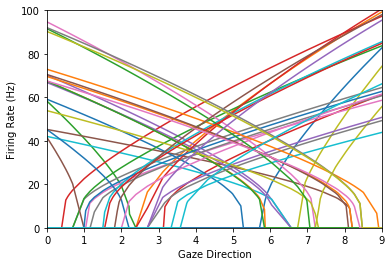

In [260]:
# ***** YOUR CODE HERE *****
plt.clf()
plt.axis([0.0,9.0,0.0,100.0])

for i in range(N):
    plt.plot(X,A[:,i])
plt.xlabel("Gaze Direction")
plt.ylabel("Firing Rate (Hz)")
plt.show()

## (c) Compute the Decoding Weights

In [261]:
# ***** YOUR CODE HERE *****
# beta = (A.T * A)\-1 * A.T * y

p1 = np.dot(A.T,A)
p1_inv = np.linalg.inv(np.matrix(p1))
p2 = np.dot(p1_inv, A.T)
coef = np.dot(p2, X)
coef = coef.reshape((40,1))

## (d) View Spike Raster of Unknown Sequence

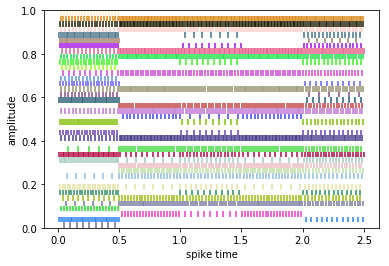

In [262]:
# ***** YOUR CODE HERE *****
import lif
plt.clf()
plt.xlabel("spike time")
plt.ylabel("amplitude")
lif.PlotSpikeRaster(Asp)

## (e) Decode the Unknown Code

In [263]:
# Spike trains for unknown sequence are stored in 'Asp'
# Asp is a list of arrays of spike trains, one array per neuron.

In [264]:
# Compute firing rates
# ***** YOUR CODE HERE *****
spikes1 = lif.CountSpikes(Asp, 0,0.5) * 2
spikes2 = lif.CountSpikes(Asp, 0.5,1) * 2
spikes3 = lif.CountSpikes(Asp, 1,1.5) * 2
spikes4 = lif.CountSpikes(Asp, 1.5,2) * 2
spikes5 = lif.CountSpikes(Asp, 2,2.5) * 2




In [265]:
# Decode unknown code

# ***** YOUR CODE HERE *****
spikes1_dir = round(np.dot(spikes1,coef)[0,0])
spikes2_dir = round(np.dot(spikes2,coef)[0,0])
spikes3_dir = round(np.dot(spikes3,coef)[0,0])
spikes4_dir = round(np.dot(spikes4,coef)[0,0])
spikes5_dir = round(np.dot(spikes5,coef)[0,0])
print ("gaze sequence {} {} {} {} {}".format(spikes1_dir,spikes2_dir,spikes3_dir,spikes4_dir,spikes5_dir))

gaze sequence 6.0 1.0 2.0 -0.0 5.0


## (f) Display the Unknown Code

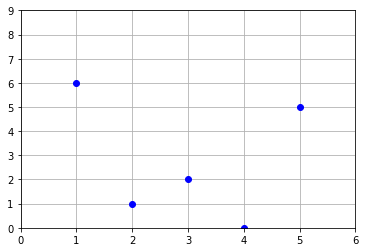

In [266]:
# ***** YOUR CODE HERE *****
plt.clf()
plt.axis([0,6,0,9])
plt.grid('on')
plt.plot(range(1,6), np.array([spikes1_dir,spikes2_dir,spikes3_dir,spikes4_dir,spikes5_dir]),'bo')
plt.show()

# Q2: LSTM

In [206]:
# You may include some Python code to help you.
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    s1 = np.exp(x) - np.exp(-x)
    s2 = np.exp(x) + np.exp(-x)
    s = s1 / s2
    return s

def cal_gates(W,v,b):
    return sigmoid(np.dot(W,v) + b)

def Ct_ht(W,b, Wc,v,bc,Ct_minus):
    gates = cal_gates(W,v,b)
    ft = gates[0]
    it = gates[1]
    ot = gates[2]
    Ct = ft * Ct_minus + tanh(np.dot(Wc,v) + bc) * it
    ht = ot * tanh(Ct)
    return ft, it, ot, Ct[0], ht[0]

## (a)

### (i)

In [207]:
# You can include some code, if you want.
W = np.array([[0,8,0,0],[0,0,9,0],[0,0,0,10]])
bc = np.array([0])
b = np.array([-4,-4.5,-5])
Wc = np.array([1,0,0,0])
v =np.array([0.05,1,0,0])
Ct_minus = np.array([-0.02])
ft,it,ot,ct,ht = Ct_ht(W,b,Wc,v,bc,Ct_minus)
print ("ft {}, it {}, ot {}, Ct {}, ht {}".format(ft,it,ot,ct,ht))
print ("Ct is quite similar to Ct_minus because forget_gate chooses to remember most of the cell while input gate and output gate is not active")

ft 0.9820137900379085, it 0.01098694263059318, ot 0.0066928509242848554, Ct -0.019091386001178278, ht -0.00012776027875546946
Ct is quite similar to Ct_minus because forget_gate chooses to remember most of the cell while input gate and output gate is not active


YOUR ANSWER HERE.

### (ii)

In [208]:
v =np.array([0.05,0,1,0])
ft,it,ot,ct,ht = Ct_ht(W,b,Wc,v,bc,Ct_minus)
print ("ft {}, it {}, ot {}, Ct {}, ht {}".format(ft,it,ot,ct,ht))
print ("Ct is almost equal to  ht_minus because input gate is almost equal to 1")

ft 0.01798620996209156, it 0.9890130573694068, ot 0.0066928509242848554, Ct 0.04904976095905828, ht 0.00032801972156155007
Ct is almost equal to  ht_minus because input gate is almost equal to 1


YOUR ANSWER HERE.

### (iii)

In [209]:
v =np.array([0.05,1,0,1])
ft,it,ot,ct,ht = Ct_ht(W,b,Wc,v,bc,Ct_minus)
print ("ft {}, it {}, ot {}, Ct {}, ht {}".format(ft,it,ot,ct,ht))
print ("Ct is almost equal to Ct_minus because of its forget_gate approaching 1.0")
print ("ht is almost equal to Ct_minus as well because the output gate is nearly 1.0 as well")

ft 0.9820137900379085, it 0.01098694263059318, ot 0.9933071490757153, Ct -0.019091386001178278, ht -0.018961306577925028
Ct is almost equal to Ct_minus because of its forget_gate approaching 1.0
ht is almost equal to Ct_minus as well because the output gate is nearly 1.0 as well


YOUR ANSWER HERE.

## (b)

In [210]:
print ("let xt = [1,1,1]")
v =np.array([0.05,1,1,1])
ft,it,ot,ct,ht = Ct_ht(W,b,Wc,v,bc,Ct_minus)
print ("ft {}, it {}, ot {}, Ct {}, ht {}".format(ft,it,ot,ct,ht))

let xt = [1,1,1]
ft 0.9820137900379085, it 0.9890130573694068, ot 0.9933071490757153, Ct 0.029769209357541942, ht 0.029561236546369364


YOUR ANSWER HERE.

## (c)

In [212]:
print ("let xt = [1/2,1/2,1/2]")
v =np.array([0.05,1/2,1/2,1/2])
ft,it,ot,ct,ht = Ct_ht(W,b,Wc,v,bc,Ct_minus)
print ("ft {}, it {}, ot {}, Ct {}, ht {}".format(ft,it,ot,ct,ht))

let xt = [1/2,1/2,1/2]
ft 0.5, it 0.5, ot 0.5, Ct 0.014979187478940002, ht 0.007489033627901628


YOUR ANSWER HERE.

# Q3: Adversarial Inputs

## Load data, get trained network, etc.

In [62]:
# Load MNIST
train, validate, test = mnist_loader.load_data_wrapper()
train_in = np.array(train[0])
train_out = np.array(train[1])

In [64]:
# Or, you can load the pretrained Network object from the supplied file,
# like this...
net = NN.Network()
net.Load('MNIST_trained_784-100-100-10.npy')

In [65]:
test_ac = NN.ClassificationAccuracy(net.FeedForward(test[0]), test[1])
print('Testing Accuracy = '+str(test_ac*100)+'%')

train_ac = NN.ClassificationAccuracy(net.FeedForward(train[0]), train[1])
print('Training Accuracy = '+str(train_ac*100)+'%')

Testing Accuracy = 97.53%
Training Accuracy = 99.136%


In [71]:
#Extract 10 digits from MNIST classified correctly by the network
x_image = []
x_class = []
for i in range(0, 10):
    while True:
        j = random.randint(0, len(test[0]))
        if np.argmax(test[1][j]) == i:
            r = net.FeedForward([test[0][j]])
            if np.argmax(r) == i:
                x_image.append(test[0][j])
                x_class.append(test[1][j])
                break

In [72]:
print (net.W[0].shape)

(784, 100)


## (a) GradientInput

In [100]:
def GradientInput(net, x, t):
    '''
        dEdx = Input_Gradient_Ascent(net, x, t)

        Computes dEdx for a network given input x and target t.
        The cost function is specified by the network.

        Inputs:
          net is the neural network
          x is the input that you want to perturb
          t is the corresponding true target vector (one-hot)
        
        Output:
          dEdx is a vector the same shape as x
    '''

    # ***** YOUR CODE HERE *****
    
    dEdx = copy.deepcopy(x)
    t = np.array(t)  # convert t to an array, in case it's not
    
    # Error gradient for top layer
    dEdz = net.TopGradient(t)

    # Loop down through the layers
    for i in range(net.n_layers - 2, 0, -1):
        pre = net.lyr[i]
        # If not the bottom layer,
        # Project error gradient down to layer below
        dEdz = (dEdz @ net.W[i].T) * pre.sigma_z_p(pre.z)
    dEdx = dEdz @ net.W[0].T

    return dEdx

In [101]:
GradientInput(net,x_image,x_class)

array([[ 6.00839960e-13, -2.75968130e-12,  2.87238052e-13, ...,
        -6.14858026e-13,  2.77906602e-12,  2.55652297e-12],
       [ 4.63209943e-16, -9.14378517e-16,  1.58491478e-15, ...,
        -1.34324951e-15, -6.27163050e-16,  1.99574801e-15],
       [ 2.19265667e-15,  3.16954808e-15, -1.56099923e-15, ...,
        -2.98668898e-15,  8.80610041e-16,  8.58381744e-16],
       ...,
       [-1.67165527e-14, -2.88785833e-15,  1.54590880e-14, ...,
         1.15951535e-14, -9.72099530e-15, -7.04318839e-15],
       [-3.89680441e-15,  1.13443116e-14,  2.08804403e-15, ...,
         7.89004114e-16, -6.19226669e-15,  8.44613155e-15],
       [ 1.56251524e-14, -8.54541390e-15,  1.90205803e-15, ...,
        -2.28903194e-15,  6.57877185e-15,  1.27907353e-14]])

## (b) FGSM

In [169]:
def FGSM(net, x_input, x_class, ep=0.05, it_lim=100000, conf=0.5, targ=False):
    '''
        x_adv = FGSM(net, x_input, x_class, ep=0.05, it_lim=100000, conf=0.5)
        
        Performs the Fast Gradient Sign Method, perturbing each input until it
        is misclassified with the specified confidence, or reaches the maximum
        number of iterations.
        
        Inputs:
          net is the Network object
          x_input is a batch of inputs
          x_class is the corresponding one-hot class vectors
          ep is the perturbation step for the FGSM
          it_lim is the maximum number of iterations
          conf is the desired confidence for the misclassification
          targ is Boolean, indicating if the FGSM is targetted
             if targ is False, then x_class is considered to be the true
             class of the input, and FGSM will work to increase the cost
             if targ is True, then x_class is considered to be the target
             class for the perturbation, and FGSM will work to decrease the cost
        
        Output:
          x_adv is a batch of adversarial inputs, the same size as x_input
    '''

    # ***** YOUR CODE HERE *****            
    
    x_adv = copy.deepcopy(x_input)
    
    loop = 0
    conf_reach = False
    if targ==False:
        while loop < it_lim and conf_reach == False:
            pred_class = net.FeedForward(x_adv)
            grad = GradientInput(net, x_adv, x_class)
            x_adv += ep * np.sign(grad)
            if loop % 1 == 0:
                print ("-----------------------------------------")
                conf_reach = True
                for x_cls, p_cls in zip(x_class, pred_class):
                    gt_label = np.argmax(x_cls)
                    pd_label = np.argmax(p_cls)
                    if pd_label == gt_label:
                        conf_reach = False
                    if pd_label != gt_label and p_cls[pd_label] < conf:
                        conf_reach = False
                    print ("digit {} classified as {} with classification value {}".format(gt_label, pd_label, p_cls[pd_label]))
            loop += 1
    
    if targ==True:
        gt_class = net.FeedForward(x_adv)
        gt_class = np.argmax(gt_class,axis=1)
        print (gt_class)
        while loop < it_lim and conf_reach == False:
            pred_class = net.FeedForward(x_adv)
            grad = GradientInput(net, x_adv, x_class)
            x_adv -= ep * np.sign(grad)
            if loop % 1 == 0:
                print ("-----------------------------------------")
                conf_reach = True
                for gt_label, p_cls, want_cls in zip(gt_class, pred_class, want_class):
                    want_label = np.argmax(want_cls)
                    pd_label = np.argmax(p_cls)
                    if pd_label != want_label:
                        conf_reach = False
                    if pd_label == want_label and p_cls[pd_label] < conf:
                        conf_reach = False
                    print ("perturbed {} classified as {} with classification value {}".format(gt_label, pd_label, p_cls[pd_label]))
            loop += 1
    
    
    return np.array(x_adv)

## (c) Untargetted Adversarial Perturbation

-----------------------------------------
digit 0 classified as 0 with classification value 0.9970813631190377
digit 1 classified as 1 with classification value 0.9939597827312049
digit 2 classified as 2 with classification value 0.9978052884876294
digit 3 classified as 3 with classification value 0.999472831528425
digit 4 classified as 4 with classification value 0.9991102229768432
digit 5 classified as 5 with classification value 0.9999917065184624
digit 6 classified as 6 with classification value 0.9983293816546159
digit 7 classified as 7 with classification value 0.9981949426965376
digit 8 classified as 8 with classification value 0.9999767892937004
digit 9 classified as 9 with classification value 0.9995467266456294
-----------------------------------------
digit 0 classified as 0 with classification value 0.9966721476250532
digit 1 classified as 1 with classification value 0.9928072781929113
digit 2 classified as 2 with classification value 0.9973890482839047
digit 3 classified a

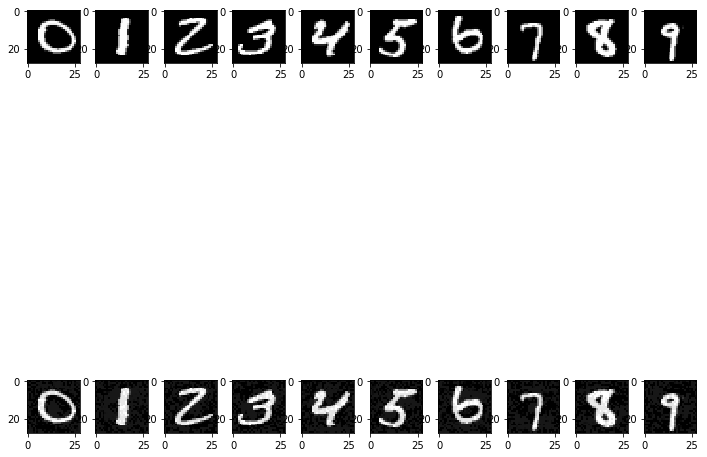

In [170]:
# ***** YOUR CODE HERE *****
x_adjust = FGSM(net, x_image,x_class,ep=0.001)
fig = plt.figure(figsize=(12, 13))
plt.subplots_adjust(hspace=0.1,wspace=0.3)
for idx in range(10):
    im = np.array(x_image[idx])
    im = im.reshape(28,28)
    plotwindow = fig.add_subplot(2,10,idx + 1)
    plt.imshow(im , cmap='gray')
    plotwindow = fig.add_subplot(2,10,10 + idx + 1)
    im_adjust = np.array(x_adjust[idx])
    im_adjust = im_adjust.reshape(28,28)
    plt.imshow(im_adjust, cmap='gray')


## (d) Targetted Adversarial Perturbation

[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
[5 1 7]
-----------------------------------------
perturbed 5 classified as 5 with classification value 0.9999917065184624
perturbed 1 classified as 1 with classification value 0.9939597827312049
perturbed 7 classified as 7 with classification value 0.9981949426965376
-----------------------------------------
perturbed 5 classified as 5 with classification value 0.9999677217057139
perturbed 1 classified as 1 with classification value 0.9800070338523147
perturbed 7 classified as 7 with classification value 0.9883367163083824
-----------------------------------------
perturbed 5 classified as 5 with classification value 0.9997872461452812
perturbed 1 classified as 1 with classification value 0.924786282240428
perturbed 7 classified as 7 with classification value 0.9300452615984146
-----------------------------------------
perturbed 5 classified as 5 with classification value 0.997687316136

<Figure size 432x288 with 0 Axes>

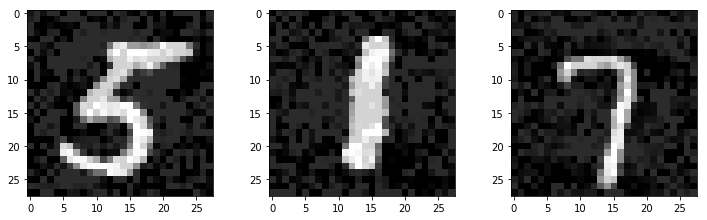

In [174]:
# ***** YOUR CODE HERE *****
want_class = np.zeros([3,10])
want_class[0,3] = 1
want_class[1,0] = 1
want_class[2,6] = 1
print (want_class)
input_image = np.zeros([3,784])
input_image[0] = x_image[5]
input_image[1] = x_image[1]
input_image[2] = x_image[7]
x_adjust = FGSM(net, input_image,want_class,ep=0.01, conf=0.8, targ=True)
plt.clf()
fig = plt.figure(figsize=(12, 13))
plt.subplots_adjust(hspace=0.1,wspace=0.3)
for idx in range(3):
    im = np.array(x_adjust[idx])
    im = im.reshape(28,28)
    plotwindow = fig.add_subplot(1,3,idx + 1)
    plt.imshow(im , cmap='gray')